# Assignment 1

In [25]:
from scipy import io
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import copy
import tikzplotlib
import seaborn
import typing
import pickle
from scipy.io.wavfile import write
%matplotlib notebook
plt.style.use('ggplot')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
np.random.seed(1)

In [2]:
# load dataset
filepath = os.path.abspath('./../../../data/ass_01/amp_data.mat')
assert os.path.exists(filepath), 'Please download the dataset. I cannot find it at: %s' %(filepath)
file = io.loadmat(filepath)
amp_data = file['amp_data']

# Question 1

### question 1a

<IPython.core.display.Javascript object>


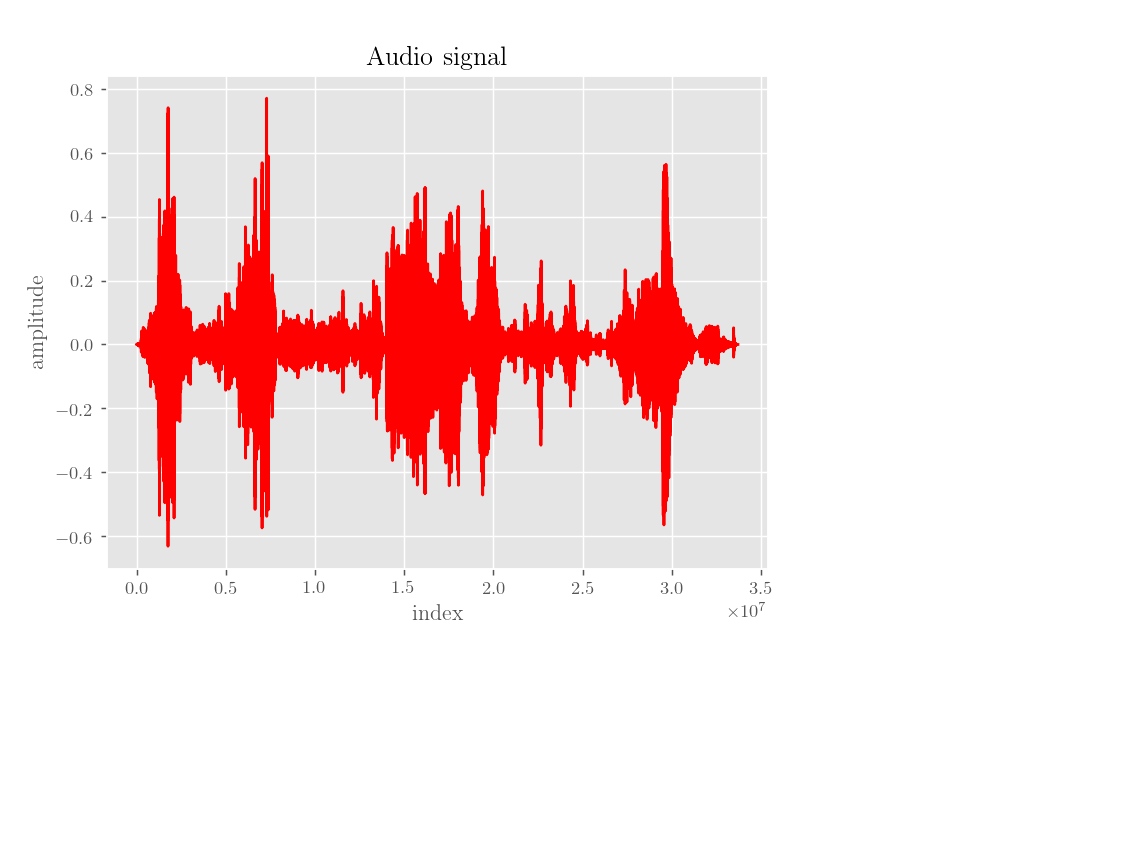

<IPython.core.display.Javascript object>


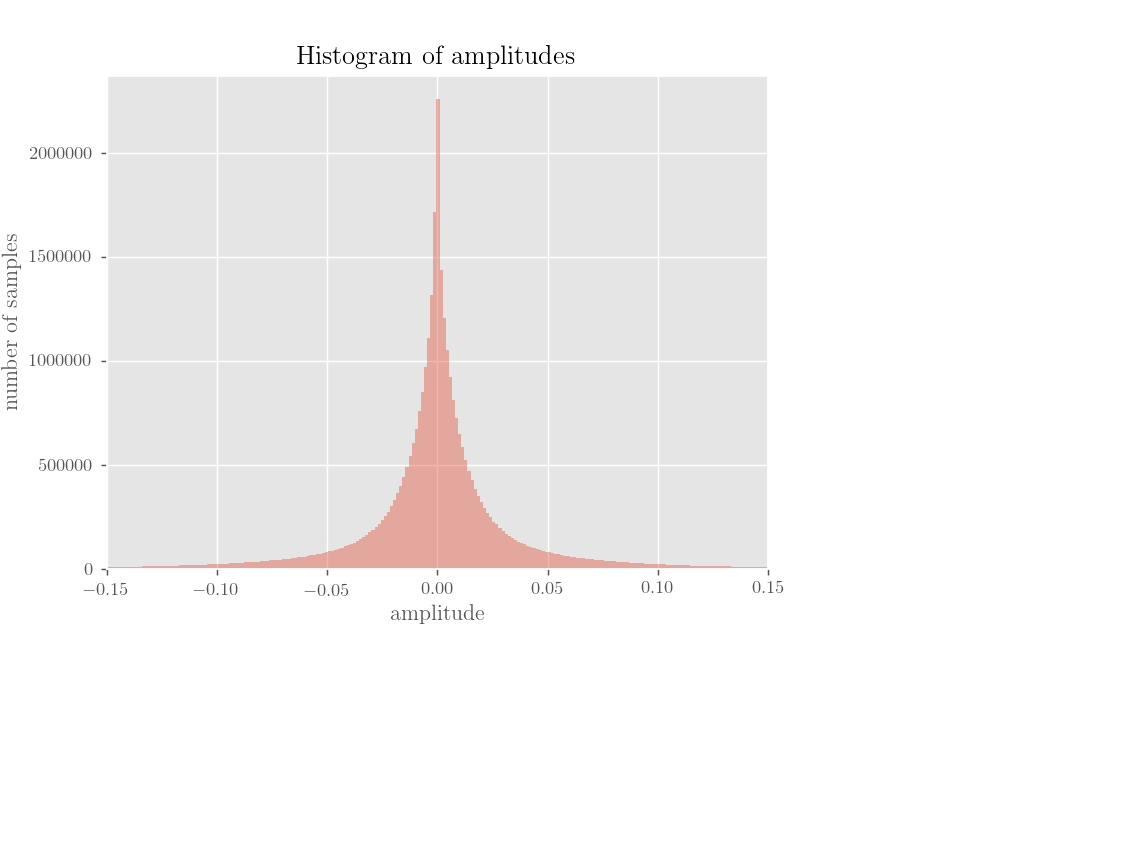

In [50]:
# plot data along t axis
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_01.pdf")
# save_filename_tex = os.path.abspath("./presentation/presentation_figures/fig_01.tex")

plt.figure()
plt.title("Audio signal")
plt.plot(amp_data[:, 0], 'r')
plt.xlabel('index')
plt.ylabel('amplitude')
plt.savefig(save_filename_png)
plt.show()
# tikzplotlib.save(save_filename_tex)

# plot histogram
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_02.pdf")
plt.figure()
plt.title("Histogram of amplitudes")
seaborn.distplot(amp_data[:, 0], bins=1000, kde=False, norm_hist=False)
plt.xlim((-0.15, 0.15))
plt.xlabel('amplitude')
plt.ylabel('number of samples')
plt.savefig(save_filename_png)
plt.show()

### question 1b

In [51]:
class Dataset:
    amp_data = amp_data
    
    def __init__(self, D: int, split_pcg = [0.7, 0.15, 0.15]):
        """
        
        :param D: dimensionality 
        """
        
        # rearrange signal into non-overlapping arrays of shape [N x D+1]
        self.remaining_samples = amp_data.shape[0] % (D+1)
        self.XY = amp_data[:-self.remaining_samples] if self.remaining_samples > 0 else amp_data
        self.XY = self.XY.reshape((int(self.XY.shape[0]/(D+1)), (D+1)))
        
        # shuffle (not inplace)
        self.shuffle_indices = np.random.permutation(self.XY.shape[0])
        self.XY_shuffled = np.take(self.XY, self.shuffle_indices, axis=0)
        
        # split into training
        self.nof_tr = np.int(np.floor(self.XY.shape[0] * split_pcg[0]))
        self.nof_val = np.int(np.floor(self.XY.shape[0] * split_pcg[1]))
        self.nof_test = np.int(np.floor(self.XY.shape[0] * split_pcg[2]))
        
        train_start = 0
        val_start = self.nof_tr
        test_start = self.nof_tr + self.nof_val
        
        self.X_shuf_train = self.XY_shuffled[0 : self.nof_tr, :D]
        self.y_shuf_train = self.XY_shuffled[0 : self.nof_tr, D]
        
        self.X_shuf_val = self.XY_shuffled[val_start : val_start + self.nof_val, :D]
        self.y_shuf_val = self.XY_shuffled[val_start : val_start + self.nof_val, D]
        
        self.X_shuf_test = self.XY_shuffled[test_start : test_start + self.nof_test, :D]
        self.y_shuf_test = self.XY_shuffled[test_start : test_start + self.nof_test, D]
    
D = 20
split_pcg = [0.7, 0.15, 0.15]
data = Dataset(D, split_pcg)

# Question 2

### question 2a

In [5]:
# # plot single row 
# save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_03.png")
# i = 1000 # nof row

# plt.figure()
# plt.plot(np.linspace(0, 19/20, 20), data.X_shuf_train[i], 'r-o', label="amplitudes");
# plt.plot(1, data.y_shuf_train[i], 'g-o', label = "label");
# plt.legend();
# plt.savefig(save_filename_png)
# plt.show(block=False);

<IPython.core.display.Javascript object>


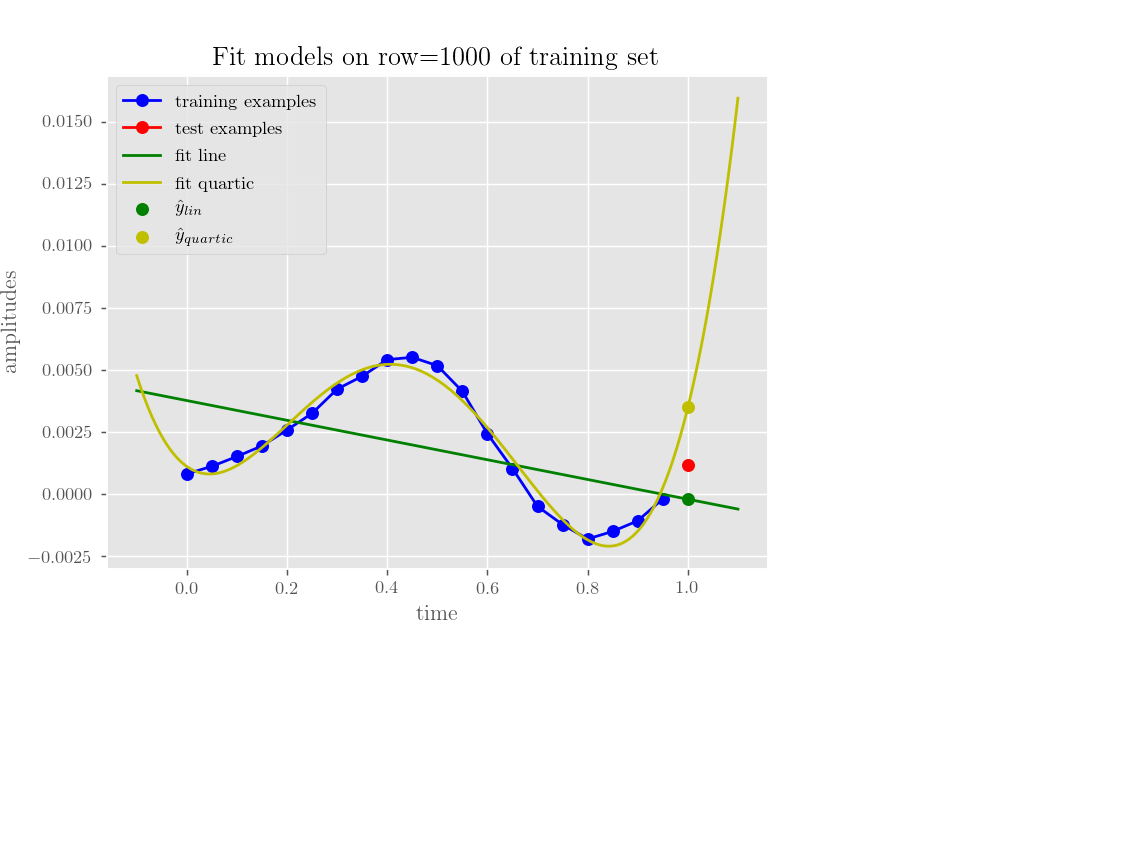

In [53]:
class Model:
    def __init__(self, phi):
        self.phi = phi
        self.w = None
        
    def fit(self, x: np.array, y: np.array):
        '''
        x: NxD
        y: Nx1
        
        w : Kx1
        '''
        assert len(y.shape) == 2
        assert len(x.shape) == 2
        assert x.shape[0] == y.shape[0]
        
        phi_x = self.phi(x)
        assert len(phi_x.shape) == 2
        assert phi_x.shape[0] == x.shape[0]
        
        w, residuals, rank, sv = np.linalg.lstsq(phi_x, y, rcond=None)
        self.w = w
        self.residuals = residuals
        
        assert len(self.w.shape) == 2
        assert self.w.shape[0] == phi_x.shape[1]
        assert self.w.shape[1] == 1
        return w
    
    def predict(self, x: np.array):
        '''
        x : NxD
        
        Nx1
        '''
        assert len(x.shape) == 2
        phi_x = self.phi(x)
        assert len(phi_x.shape) == 2
        assert phi_x.shape[0] == x.shape[0]
        assert phi_x.shape[1] == self.w.shape[0]
        
        return np.matmul(phi_x, self.w)
    
    
    def mse(self, X, Y):
        '''
        X : NxD
        Y : Nx1
        
        scalar
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        Y_pred.shape
        assert Y_pred.shape == Y.shape
        return np.mean(np.square(Y - Y_pred))
    
    def mae(self, X, Y):
        '''
        X : NxD
        Y : Nx1
        
        scalar
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        assert Y_pred.shape == Y.shape
        return np.mean(np.abs(Y - Y_pred))

def affine_phi(x):
    assert len(x.shape) == 2
    phi_x = np.concatenate((np.ones_like(x), x), axis=1)
    return phi_x

def quartic_phi(x):
    assert len(x.shape) == 2
    phi_x = np.concatenate((np.ones_like(x), x, x**2, x**3, x**4), axis=1)
    return phi_x


linear_model = Model(phi=affine_phi)
quartic_model = Model(phi=quartic_phi)

i = 1000 # nof row
x = np.expand_dims(np.linspace(0, 19 / 20, 20), -1)
y = np.expand_dims(data.X_shuf_train[i], -1)

linear_model.fit(x, y)
quartic_model.fit(x, y)

x_ext = np.expand_dims(np.linspace(-0.1, 1.1, 200), -1)

# subquestion a
plt.figure()
plt.title('Fit models on row=1000 of training set')
# training points
plt.plot(x, y, 'b-o', label = 'training examples')
# test point
plt.plot(np.array([[1]]), data.y_shuf_train[i], 'r-o', label = 'test examples')

# fit line
plt.plot(x_ext, linear_model.predict(x_ext), 'g-', label = 'fit line')
# fit quartic
plt.plot(x_ext, quartic_model.predict(x_ext), 'y-', label = 'fit quartic')

# prediction of linear model
plt.plot(np.array([[1]]), linear_model.predict(np.array([[1]])), 'go', label = '$\hat{y}_{lin}$')
# prediction of quartic model
plt.plot(np.array([[1]]), quartic_model.predict(np.array([[1]])), 'yo', label = '$\hat{y}_{quartic}$')

plt.xlabel("time")
plt.ylabel("amplitudes")
plt.legend();
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_03.pdf")
plt.savefig(save_filename_png)
plt.show(block=False)

In [7]:
# evaluate linear model
mae_tr = linear_model.mae(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))
mae_val = linear_model.mae(np.ones((data.y_shuf_val.shape[0], 1)), np.expand_dims(data.y_shuf_val, -1))
mae_test = linear_model.mae(np.ones((data.y_shuf_test.shape[0], 1)), np.expand_dims(data.y_shuf_test, -1))

print("Linear model, mae on training set: %.5f" %mae_tr)
print("Linear model, mae on training set: %.5f" %mae_val)
print("Linear model, mae on training set: %.5f" %mae_test)

Linear model, mae on training set: 0.02343
Linear model, mae on training set: 0.02353
Linear model, mae on training set: 0.02328


In [8]:
# evaluate quartic model
mae_tr = quartic_model.mae(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))
mae_val = quartic_model.mae(np.ones((data.y_shuf_val.shape[0], 1)), np.expand_dims(data.y_shuf_val, -1))
mae_test = quartic_model.mae(np.ones((data.y_shuf_test.shape[0], 1)), np.expand_dims(data.y_shuf_test, -1))

print("Quartic model, mae on training set: %.5f" %mae_tr)
print("Quartic model, mae on training set: %.5f" %mae_val)
print("Quartic model, mae on training set: %.5f" %mae_test)

Quartic model, mae on training set: 0.02388
Quartic model, mae on training set: 0.02398
Quartic model, mae on training set: 0.02374


## Question 3

### question b

In [9]:
C = 20
K = 3
def Phi(C, K):
    t = np.linspace(0, (C-1)/C, C)
    return np.stack([t**k for k in range(K)], axis=1)

In [10]:
def phi_t(t, K):
    return np.expand_dims(np.array([t**k for k in range(K)]), -1)

def make_vv(C, K, x):
    F = Phi(C,K)
    F_T = np.transpose(F)
    f_t1 = phi_t(1, K)
    f_1 = np.linalg.inv(F_T.dot(F))
    f_2 = F_T.dot(x)
    f_3 = (f_1.dot(f_2)).T
    f_4 = f_3.dot(f_t1)
    f_5 = f_4.dot(x.T).T
    f_6 = f_5/ np.sum(np.square(x))
    return f_6

In [11]:
inp = np.array([[1]])
C = 20
K = 5
x = np.expand_dims(data.X_shuf_train[i], -1)

# demonstration for linear model
v1 = make_vv(C, 2, x)
assert np.allclose(linear_model.predict(inp), v1.T.dot(x))

# demonstration for quartic model
v2 = make_vv(C, 5, x)
assert np.allclose(quartic_model.predict(inp), v2.T.dot(x))

### question c

In [15]:
# train and validate models on a grid
def phi(c: int, K: typing.List) -> np.array:
    assert len(x.shape) == 2
    assert c > 0
    assert c <= 20
    
    def phi_ck(x: np.array) -> np.array:
        x = x[:,-c:]
    
        phi_x = np.stack([x**k for k in K], axis=2)
        N = phi_x.shape[0]
        phi_x = phi_x.reshape((N, -1))
        assert len(phi_x.shape) == 2
        return phi_x
    return phi_ck

C = np.arange(1, 21)
K = np.arange(1, 10)

if os.path.exists(os.path.abspath('./model_statistics_3c.p')):
    with open('./model_statistics_3c.p', 'rb') as fm:
        statistics = pickle.load(fm)
    mse_error_tr = statistics['tr_err']
    mse_error_val = statistics['val_err']
    mse_error_te = statistics['test_err']
else:
    mse_error_tr = []
    mse_error_val = []
    mse_error_te = []
    for i, c in enumerate(C):
        mse_error_tr.append([])
        mse_error_val.append([])
        mse_error_te.append([])
        for k in K:
            tmp_model = Model(phi(c, np.arange(k)))
            tmp_model.fit(np.expand_dims(data.X_shuf_train[i], 0), np.array([[data.y_shuf_train[i]]]))

            mse_error_tr[i].append(tmp_model.mse(data.X_shuf_train, np.expand_dims(data.y_shuf_train, -1)))
            mse_error_val[i].append(tmp_model.mse(data.X_shuf_val, np.expand_dims(data.y_shuf_val, -1)))
            mse_error_te[i].append(tmp_model.mse(data.X_shuf_test, np.expand_dims(data.y_shuf_test, -1)))

    mse_error_tr = np.array(mse_error_tr)
    mse_error_val = np.array(mse_error_val)
    mse_error_te = np.array(mse_error_te)
    
    with open('./model_statistics_3c.p', 'wb') as fm:
        pickle.dump({'tr_err': mse_error_tr, 'val_err': mse_error_val, 'test_err': mse_error_te}, fm)

In [17]:
# get the best model
best_tr_model = np.unravel_index(np.argmin(mse_error_tr, axis=None), mse_error_tr.shape)
best_val_model = np.unravel_index(np.argmin(mse_error_val, axis=None), mse_error_val.shape)
best_te_model = np.unravel_index(np.argmin(mse_error_te, axis=None), mse_error_te.shape)

# print(best_tr_model)
# print(best_val_model)
# print(best_te_model)

# results of best val model
print("best model on validation set is the one with %d previous points and %d basis functions" %(C[best_val_model[0]], K[best_val_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_val_model]))
print("mse on validation set: %.10f" %mse_error_val[best_val_model])
print("mse on test set: %.10f" %mse_error_te[best_val_model])

print("\nbest model on training set is the one with %d previous points and %d basis functions" %(C[best_tr_model[0]], K[best_val_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_val_model]))
print("mse on validation set: %.10f" %mse_error_val[best_val_model])
print("mse on test set: %.10f" %mse_error_te[best_val_model])

print("\nbest model on test set is the one with %d previous points and %d basis functions" %(C[best_te_model[0]], K[best_val_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_val_model]))
print("mse on validation set: %.10f" %mse_error_val[best_val_model])
print("mse on test set: %.10f" %mse_error_te[best_val_model])


# plt.figure()
# for i in [1, 2, 3, 4, 5]:
#     plt.plot(np.arange(6,15), mse_error_tr[5:,i])
#     plt.plot(np.arange(6,15), mse_error_val[5:,i])
# plt.show()

best model on validation set is the one with 20 previous points and 2 basis functions
mse on training set: 0.0017272516
mse on validation set: 0.0017446172
mse on test set: 0.0016971767

best model on training set is the one with 20 previous points and 2 basis functions
mse on training set: 0.0017272516
mse on validation set: 0.0017446172
mse on test set: 0.0016971767

best model on test set is the one with 20 previous points and 2 basis functions
mse on training set: 0.0017272516
mse on validation set: 0.0017446172
mse on test set: 0.0016971767


# Question 4

In [12]:
def new_affine_phi(X):
    assert len(X.shape) == 2, "Shape of all thing must have length 2"
    raw_ones_column = np.expand_dims(np.ones(X.shape[0]), -1)
    return np.concatenate((X, raw_ones_column), axis=1)

affine_model = Model(new_affine_phi)
w = affine_model.fit(data.X_shuf_train, np.expand_dims(data.y_shuf_train, -1))

mse_tr = []
mse_val = []
mse_te = []
affine_model = []
C = np.arange(1, 21)
for i, c in enumerate(C):
    affine_model.append(Model(new_affine_phi))
    affine_model[i].fit(data.X_shuf_train[:,-c:], np.expand_dims(data.y_shuf_train, -1))
    train_err = affine_model[i].mse(data.X_shuf_train[:,-c:], np.expand_dims(data.y_shuf_train, -1))
    valid_err = affine_model[i].mse(data.X_shuf_val[:,-c:], np.expand_dims(data.y_shuf_val, -1))
    test_err = affine_model[i].mse(data.X_shuf_test[:,-c:], np.expand_dims(data.y_shuf_test, -1))
    mse_tr.append(train_err)
    mse_val.append(valid_err)
    mse_te.append(test_err)
    
mse_tr = np.array(mse_tr)
mse_val = np.array(mse_val)
mse_te = np.array(mse_te)

c_arg = np.argmin(mse_val)
print("best model on validation is the one with %d previous points" %C[c_arg])
print("mse on training set: %.10f" %mse_tr[c_arg])
print("mse on validation set: %.10f" %mse_val[c_arg])
print("mse on test set: %.10f" %mse_te[c_arg])


c_arg = np.argmin(mse_tr)
print("best model on training set is the one with %d previous points" %C[c_arg])
print("mse on training set: %.10f" %mse_tr[c_arg])
print("mse on validation set: %.10f" %mse_val[c_arg])
print("mse on test set: %.10f" %mse_te[c_arg])

best model on validation is the one with 18 previous points
mse on training set: 0.0000076631
mse on validation set: 0.0000077528
mse on test set: 0.0000081110
best model on training set is the one with 20 previous points
mse on training set: 0.0000076593
mse on validation set: 0.0000077551
mse on test set: 0.0000081285


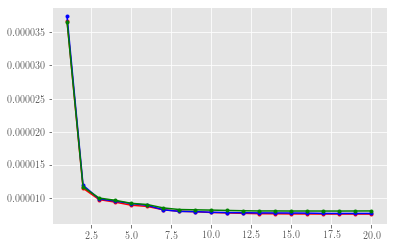

In [18]:
# plot results
plt.figure()
plt.plot(C, mse_tr, 'r.-')
plt.plot(C, mse_val, 'b.-')
plt.plot(C, mse_te, 'g.-')
plt.show()

<IPython.core.display.Javascript object>


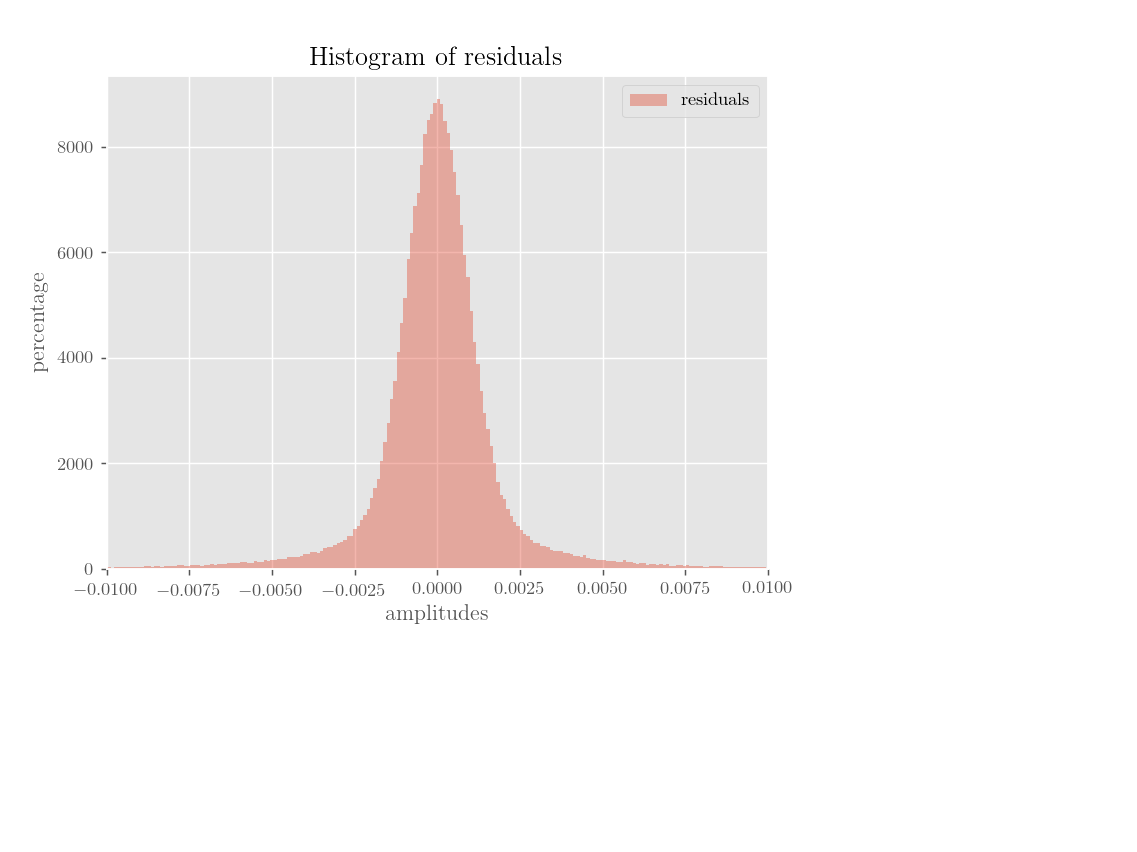

<IPython.core.display.Javascript object>


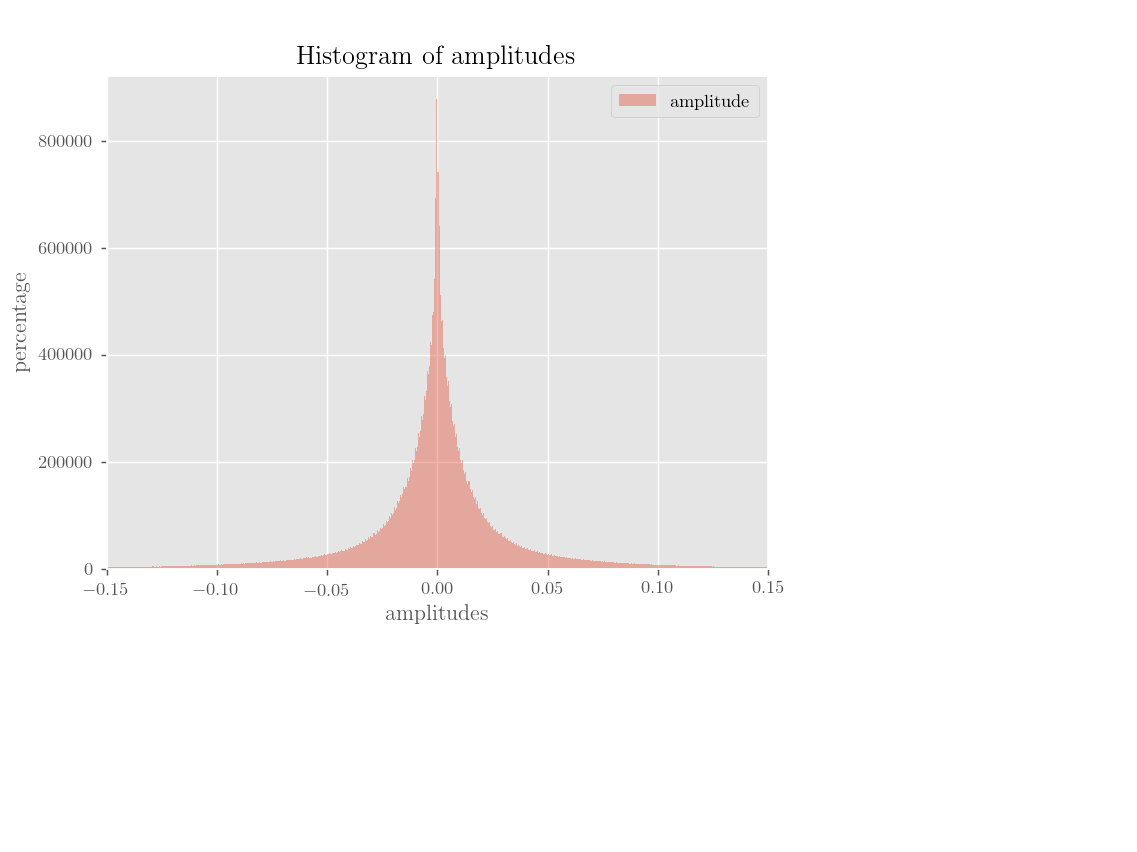

In [54]:
plt.figure()
plt.title("Histogram of residuals")
res = affine_model[c_arg].predict(data.X_shuf_val[:,-C[c_arg]:]) - np.expand_dims(data.y_shuf_val, -1)
seaborn.distplot(res, bins = 3000, kde=False, norm_hist=False, label= 'residuals')
# seaborn.distplot(amp_data[:, 0], bins=1000, kde=False, norm_hist=False, label = 'amplitude')
plt.xlabel('amplitudes')
plt.ylabel('percentage')
plt.xlim((-0.01, 0.01))
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_04.pdf")
plt.legend()
plt.savefig(save_filename_png)
plt.show()

plt.figure()
plt.title("Histogram of amplitudes")
res = affine_model[c_arg].predict(data.X_shuf_val[:,-C[c_arg]:]) - np.expand_dims(data.y_shuf_val, -1)
# seaborn.distplot(res, bins = 1000, kde=False, norm_hist=False, label= 'residuals')
seaborn.distplot(amp_data[:, 0], bins=3000, kde=False, norm_hist=False, label = 'amplitude')
plt.xlabel('amplitudes')
plt.ylabel('percentage')
plt.xlim((-0.15, 0.15))
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_05.pdf")
plt.legend()
plt.savefig(save_filename_png)
plt.show()

## What next?? add best of all models

In [55]:
# train and validate models on a grid
def phi(c: int, K: typing.List) -> np.array:
    assert len(x.shape) == 2
    assert c > 0
    assert c <= 20
    
    def phi_ck(x: np.array) -> np.array:
        x = x[:,-c:]
    
        phi_x = np.stack([x**k for k in K], axis=2)
        N = phi_x.shape[0]
        phi_x = phi_x.reshape((N, -1))
        assert len(phi_x.shape) == 2
        return phi_x
    return phi_ck


C = np.arange(1, 21)
K = np.arange(1, 10)

if os.path.exists(os.path.abspath('./model_statistics.p')):
    with open('./model_statistics.p', 'rb') as fm:
        statistics = pickle.load(fm)
    mse_error_tr = statistics['tr_err']
    mse_error_val = statistics['val_err']
    mse_error_te = statistics['test_err']
else:
    mse_error_tr = []
    mse_error_val = []
    mse_error_te = []
    for i, c in enumerate(C):
        mse_error_tr.append([])
        mse_error_val.append([])
        mse_error_te.append([])
        for k in K:
            tmp_model = Model(phi(c, np.arange(k)))
            tmp_model.fit(data.X_shuf_train, np.expand_dims(data.y_shuf_train, -1))

            mse_error_tr[i].append(tmp_model.mse(data.X_shuf_train, np.expand_dims(data.y_shuf_train, -1)))
            mse_error_val[i].append(tmp_model.mse(data.X_shuf_val, np.expand_dims(data.y_shuf_val, -1)))
            mse_error_te[i].append(tmp_model.mse(data.X_shuf_test, np.expand_dims(data.y_shuf_test, -1)))

    mse_error_tr = np.array(mse_error_tr)
    mse_error_val = np.array(mse_error_val)
    mse_error_te = np.array(mse_error_te)

In [57]:
# get the best model
best_tr_model = np.unravel_index(np.argmin(mse_error_tr, axis=None), mse_error_tr.shape)
best_val_model = np.unravel_index(np.argmin(mse_error_val, axis=None), mse_error_val.shape)
best_te_model = np.unravel_index(np.argmin(mse_error_te, axis=None), mse_error_te.shape)

# print(best_tr_model)
# print(best_val_model)
# print(best_te_model)

# results of best train model
print("best model on training set is the one with %d previous points and %d basis functions" %(C[best_tr_model[0]], K[best_tr_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_tr_model]))
print("mse on validation set: %.10f" %mse_error_val[best_tr_model])
print("mse on test set: %.10f" %mse_error_te[best_tr_model])

# results of best val model
print("best model on validation set is the one with %d previous points and %d basis functions" %(C[best_val_model[0]], K[best_val_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_val_model]))
print("mse on validation set: %.10f" %mse_error_val[best_val_model])
print("mse on test set: %.10f" %mse_error_te[best_val_model])

# results of best val model
print("best model on test set is the one with %d previous points and %d basis functions" %(C[best_te_model[0]], K[best_te_model[1]]))
print("mse on training set: %.10f" %(mse_error_tr[best_te_model]))
print("mse on validation set: %.10f" %mse_error_val[best_te_model])
print("mse on test set: %.10f" %mse_error_te[best_te_model])

# plt.figure()
# for i in [1, 2, 3, 4, 5]:
#     plt.plot(np.arange(6,15), mse_error_tr[5:,i])
#     plt.plot(np.arange(6,15), mse_error_val[5:,i])
# plt.show()

best model on training set is the one with 20 previous points and 9 basis functions
mse on training set: 0.0000074563
mse on validation set: 0.0000111523
mse on test set: 0.0000089802
best model on validation set is the one with 18 previous points and 5 basis functions
mse on training set: 0.0000075316
mse on validation set: 0.0000076156
mse on test set: 0.0000080694
best model on test set is the one with 18 previous points and 4 basis functions
mse on training set: 0.0000075556
mse on validation set: 0.0000076496
mse on test set: 0.0000080226
